# Logistic Regression

In dit notebook wordt een document classifier geimplementeerd die tussen twee klassen kan beslissen op basis van logistic regression.

Uiteindelijk heeft deze methode voor het door ons gelabelde deel Huggingface dataset de volgende resultaten opgeleverd (dit kan net iets anders zijn als je het notebook opnieuw runt, omdat de train/test splits willekeurig gekozen worden):
- Met keyword filtering: accuracy 0.79, gemiddelde f-score 0.69
- Zonder keyword filtering: accuracy 0.95, gemiddelfe f-score 0.67

De structuur van het model is als volgt:
- Eerst wordt het artikel gepreprocessed: getokeniseerd en de tokens worden gestemd
- Vervolgens worden eventueel artikelen die bepaalde keywords (niet) bevatten uit de data gefilterd. Deze worden gezien als klasse 0 (geen ongeluk)
- Elk woord in de vocabulair krijgt een gemiddelde tf-idf score over alle documenten per klasse. De 'weight' van een woord is zijn tf-idf score op klasse 1 min de tf-idf score op klasse 0.
- De score van een artikel wordt berekend door de scores van alle woorden in dat artikel op te tellen
- De kans om bij een klasse te horen wordt berekend door lineaire regressie uit te voeren op die score

Eerst worden de nodige libraries geimporteerd. `huggingface_stats` bevat helperfuncties die wij zelf hebben geschreven, om die te kunnen importeren heb je het bestand `huggingface_stats.py` nodig.

In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re
import matplotlib.pyplot as plt
import huggingface_stats
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/erik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Hier wordt de dataset ingelezen die door ons handmatig is gelabeld. Klasse 0 betekent dat het artikel niet over een ongeluk gaat, 1 betekent dat het wel over een ongeluk gaat.

In [2]:
dataset = pd.read_csv('0-10000-labeled.csv')
dataset_docs = dataset['article'].tolist()
dataset_y = dataset['label'].astype('int').tolist()

Een preprocessor wordt gebruikt om de data te preprocessen. Dit is een class met meerdere methods, bijvoorbeeld om alle woorden in een document te tellen. De preprocesser bevat ook de code om het document te tokenisen en om artikelen op basis van keywords te filteren.

In [3]:
preprocessor = huggingface_stats.Preprocessor(stemmer=EnglishStemmer(),
                                              stopwords=stopwords.words('english'),
                                              re_pattern=re.compile("[a-zA-Z]"))

Je kunt eventueel van tevoren de documenten filteren op keywords:

In [4]:
# pas deze if-statement aan om keyword filteren aan of uit te zetten
filter_by_keywords = True
if filter_by_keywords:
    positive_keywords = ['accident','disaster','catastrophe','incident','near-miss', 'tragedy', 'victim',
                         'casualties','died','killed','damage','harm','hospital','hospitalized',
                         'wounded','succumbed','unscathed','evacuate','rescue','first responders','ambulance',
                         'first aid', 'sunk','fire','derailed','collision','poisoned','burned', 'safety']
    negative_keywords = ['gunman', 'suspect', 'attack', 'terror', 'war', 'bombing', 'militants', 'bombs',
                         'conflict', 'hijacking']
    preprocessor.init_keyword_filter(positive=positive_keywords,
                                     pos_threshold=3,
                                     negative=negative_keywords,
                                     neg_threshold=3)
    pass_filter = preprocessor.batch_keyword_filter(docs=dataset_docs, show_progress=True)
    dataset_docs = np.array(dataset_docs)[np.array(pass_filter)].tolist()
    dataset_y = np.array(dataset_y)[np.array(pass_filter)].tolist()
    

100%|██████████| 10000/10000 [01:26<00:00, 115.11it/s]


In [5]:
print('dataset contains', len(dataset_y), 'datapoints')
print('dataset contains', np.sum(np.array(dataset_y) == 0), 'documents labeled 0')
print('dataset contains', np.sum(np.array(dataset_y) == 1), 'documents labeled 1')

dataset contains 1802 datapoints
dataset contains 1344 documents labeled 0
dataset contains 458 documents labeled 1


De gelabelde dataset wordt opgesplitst in train en test set:

In [6]:
docs_train, docs_test, y_train, y_test = train_test_split(dataset_docs, dataset_y, test_size=.25)

Een 'scorer' berekent een score voor elk document. De onderstaande cel traint de scorer op de test set, dus hij leert de 'weights' van alle woorden op basis van de tf-idf in de test set. In detail gaat het proces als volgt:

- De vocabulair wordt berekend, dit is een set van alle woorden die in de dataset voor komen. Voor elk woord in de vocabulair wordt geteld hoe vaak het in totaal voor komt in de dataset.
- Er wordt per klasse geteld hoe vaak elk woord voor komt in alle documenten met dezelfde klasse
- De tf-idf van een woord $w$ voor klasse N is het logaritme van hoe vaak het woord gemiddeld voor komt in klasse N ($C(w)_N$), gedeeld door hoe vaak het woord totaal voorkomt in de dataset ($C(w)$). Vaak wordt hier nog 1 bij opgeteld, zodat je niet door 0 kunt delen. Dit is niet per se nodig, aangezien elk woord in de vocabulair minstens 1 keer voorkomt, maar dit hebben we toch maar gedaan.
$$\text{tf-idf}(w)_N = \log(\frac{X(w)_N}{X(w) + 1})$$
- De 'weight' van elk woord is vervolgens de tf-idf in de positieve klasse min de tf-idf in de negatieve klasse:
$$\text{weight}(w) = \text{tf-idf}(w)_1 - \text{tf-idf}(w)_0$$

Als de scorer getraind is op de test set, kan hij voor elk document $d$ een score berekenen. Dit wordt gedaan door een simpele gewogen som:
$$\text{score}(d) = \sum_{w\in d}\text{weight}(w)$$
Als een woord niet voorkwam in de train set, is zijn weight 0.

In [7]:
scorer = huggingface_stats.tf_idf_document_scorer(preprocessor=preprocessor,
                                                  docs=docs_train,
                                                  labels=y_train,
                                                  show_progress=True)

100%|██████████| 1004/1004 [00:11<00:00, 89.34it/s]


Dit zijn de woorden die het meest en minst wegen voor class 'wel ongeluk':

In [8]:
pd.DataFrame(list(scorer._weights.items())).sort_values(1, ascending=False)

,0,1
76,plane,2.080861
958,crash,1.855912
289,pilot,1.550281
941,flood,1.439905
43,flight,1.226432
...,...,...
1597,murder,-0.825352
386,attack,-0.857155
1659,shoot,-0.860494
7791,knox,-0.910178


In [9]:
X_train = scorer.batch_score(docs_train, show_progress=True)

100%|██████████| 1351/1351 [00:13<00:00, 102.76it/s]


Dit zijn de scores die de scorer berekent voor enkele positief gelabelde documenten:

In [10]:
np.array(X_train)[np.array(y_train) == 1][:50]

array([ 23.70270061,   7.82383301,  25.55411823,  -1.26542861,
        43.66734713,   6.7683159 ,  33.31741945,  10.84632264,
        68.69975744,  52.08025704,  12.97613965,  13.67672051,
        34.70682575,   2.66019186,   3.97130258,  39.55854135,
        -0.4338712 ,  76.82522579,  41.56329617,  -4.74923546,
        68.48052766,   5.08932277,  -9.8766531 ,  35.67533068,
         5.70583247,  20.63838453,  15.52244018,  17.97059238,
        34.06291027,  -3.08022121,  11.2844577 , -45.2277479 ,
       -23.06921993,  -4.19081038,  39.86172438,  80.05493749,
         3.31732308,  15.6833566 ,  32.92984112,  -4.99554347,
        -8.73406769,  35.94360458, -12.43782481,  47.86889495,
        -6.97194566,  28.79865716,  10.07863166,   4.02390404,
        30.04286816,  16.41272631])

Dit zijn de scores die de scorer berekent voor enkele negatief gelabelde documenten:

In [11]:
np.array(X_train)[np.array(y_train) == 0][:50]

array([ -16.29449915,  -10.563237  ,  -23.46483383,   81.91670461,
        -20.49208778,  -50.03803837,   22.7259469 ,   29.19942399,
        -98.17135115,  -69.95825633,  -35.27579908,  -22.92342318,
          6.83526294,  -72.02753419,  -63.69974712,  -66.84054178,
         -9.00423059,  -49.49785578,  -62.4177592 ,  -76.29436784,
        -57.85851378,  -62.1727556 ,   -7.56860384,  -52.4782782 ,
        -34.98122168,  -72.67530221,   -0.4435139 ,   88.96589439,
        -42.58358128,  -15.74590804,  -53.03024278,  -61.34134125,
        -48.201872  , -107.56315712,  -44.22558395,  -25.4726162 ,
        -42.55170775,  -69.82416432,  -52.07902584,  -38.26978354,
        -80.65701762,   -8.46707669,  -32.11006043,  -10.78444151,
        -41.70873938,  -23.31570601,    8.58670383,  -11.220103  ,
        -43.37109794,   39.95788944])

Zoals je misschien al kon zien, overlappen de positief en negatief gelabelde documenten enigzins in hun score. Hier is de true class uitgezet tegen de berekende score:

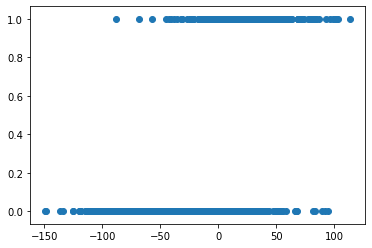

In [12]:
plt.scatter(X_train, y_train)

Met die score kan vervolgens logistieke regressie gedaan worden. We gebruiken een standaard `LogisticRegression` model van SKlearn:

In [13]:
model = LogisticRegression(random_state=0).fit(np.array([X_train]).T, y_train)

In [14]:
X_test = scorer.batch_score(docs_test, show_progress=True)

100%|██████████| 451/451 [00:04<00:00, 100.69it/s]


In [15]:
y_predict = model.predict(np.array([X_test]).T)

Performance:

In [16]:
print(classification_report(y_test, y_predict, target_names=['not accident', 'accident']))

              precision    recall  f1-score   support

not accident       0.87      0.92      0.89       340
    accident       0.70      0.57      0.63       111

    accuracy                           0.83       451
   macro avg       0.78      0.74      0.76       451
weighted avg       0.83      0.83      0.83       451

